# Convolutional Neural Networks

Realizaremos un ejercicio descrito en el blog www.aprendemachinelearning.com para hacer reconocimiento de imágenes.

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


# Cargar set de Imágenes

In [7]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep
imgpath

'C:\\Formaciones\\Python\\Ejemplos_git\\git_jbagnato\\machine-learning\\sportimages\\'

In [8]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\americano 1
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\basket 9348
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\beisball 8823
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\boxeo 7752
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\ciclismo 7125
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\f1 7533
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\futbol 5053
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\golf 7617
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\natacion 9768
C:\Formaciones\Python\Ejemplos_git\git_jbagnato\machine-learning\sportimages\tenis 5172
Directorios l

# Creamos las etiquetas

In [10]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  77128


In [12]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 americano
1 basket
2 beisball
3 boxeo
4 ciclismo
5 f1
6 futbol
7 golf
8 natacion
9 tenis


In [13]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


# Creamos Sets de Entrenamiento y Test

In [14]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5, 1.0, 'Ground Truth : 7')

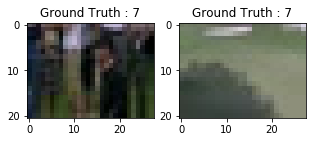

In [15]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

In [16]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

## Hacemos el One-hot Encoding para la red

In [17]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 7
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [18]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [19]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


# Creamos el modelo de CNN

In [20]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [21]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
sport_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 28, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 21, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4928)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                157728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
__________

In [23]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [24]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# como ejemplo, en mi Macbook pro tarda 4 minutos
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Instructions for updating:
Use tf.cast instead.
Train on 49361 samples, validate on 12341 samples
Epoch 1/6
49361/49361 [==============================] - 32s 654us/step - loss: 1.4644 - acc: 0.5175 - val_loss: 0.9879 - val_acc: 0.7758
Epoch 2/6
49361/49361 [==============================] - 34s 689us/step - loss: 1.1527 - acc: 0.6235 - val_loss: 0.8432 - val_acc: 0.8208
Epoch 3/6
49361/49361 [==============================] - 34s 698us/step - loss: 1.0459 - acc: 0.6613 - val_loss: 0.7504 - val_acc: 0.8313
Epoch 4/6
49361/49361 [==============================] - 33s 674us/step - loss: 0.9766 - acc: 0.6864 - val_loss: 0.7023 - val_acc: 0.8413
Epoch 5/6
49361/49361 [==============================] - 35s 712us/step - loss: 0.9359 - acc: 0.7028 - val_loss: 0.6637 - val_acc: 0.8494
Epoch 6/6
49361/49361 [==============================] - 37s 759us/step - loss: 0.9026 - acc: 0.7117 - val_loss: 0.6344 - val_acc: 0.8541


In [25]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist_CNN_imagenes_deportivas.h5py")

# Evaluamos la red

In [26]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

15426/15426 [==============================] - 3s 218us/step


In [27]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6328174531050235
Test accuracy: 0.8560223000129651


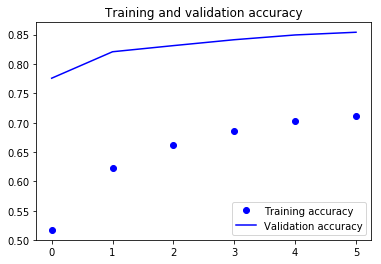

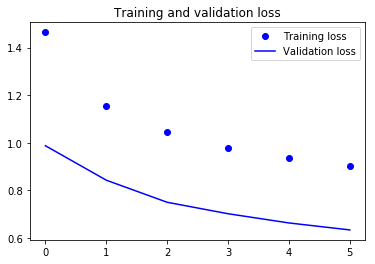

In [28]:
accuracy = sport_train.history['acc']
val_accuracy = sport_train.history['val_acc']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
predicted_classes2 = sport_model.predict(test_X)

In [30]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [31]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

# Aprendamos de los errores: Qué mejorar

Found 13205 correct labels


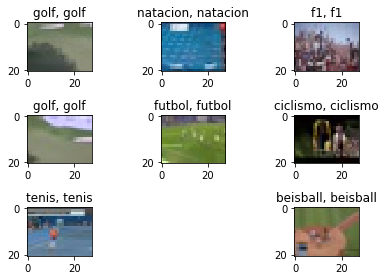

In [32]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

### Errores

Found 2221 incorrect labels


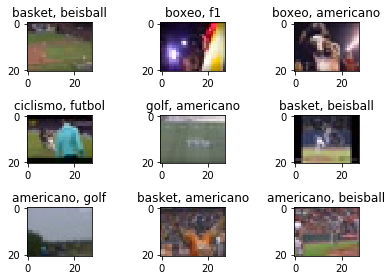

In [33]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [35]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.70      0.73      0.71      1847
     Class 1       0.84      0.88      0.86      1723
     Class 2       0.84      0.75      0.79      1613
     Class 3       0.86      0.94      0.90      1372
     Class 4       0.97      0.99      0.98      1540
     Class 5       0.81      0.49      0.61       988
     Class 6       0.93      0.86      0.90      1544
     Class 7       0.75      0.89      0.81      1966
     Class 8       0.95      0.93      0.94      1043
     Class 9       0.98      1.00      0.99      1790

   micro avg       0.86      0.86      0.86     15426
   macro avg       0.86      0.85      0.85     15426
weighted avg       0.86      0.86      0.85     15426



### Ejecucion actual

       precision    recall  f1-score   support

     Class 0       0.70      0.73      0.71      1847 AMERICANO --> PEOR
     Class 1       0.84      0.88      0.86      1723 BASKET
     Class 2       0.84      0.75      0.79      1613 BEISBALL
     Class 3       0.86      0.94      0.90      1372 BOXEO
     Class 4       0.97      0.99      0.98      1540 CICLISMO
     Class 5       0.81      0.49      0.61       988 F1
     Class 6       0.93      0.86      0.90      1544 FUTBOL
     Class 7       0.75      0.89      0.81      1966 GOLF
     Class 8       0.95      0.93      0.94      1043 NATACION
     Class 9       0.98      1.00      0.99      1790 TENIS --> MEJOR

   micro avg       0.86      0.86      0.86     15426
   macro avg       0.86      0.85      0.85     15426
weighted avg       0.86      0.86      0.85     15426



- 0 americano
- 1 basket
- 2 beisball
- 3 boxeo
- 4 ciclismo
- 5 f1
- 6 futbol
- 7 golf
- 8 natacion
- 9 tenis

Imagenes por directorio
[9349, 8823, 7752, 7125, 7533, 5053, 7617, 9768, 5172, 8936]







## Ejemplo de otra ejecucion



            precision    recall  f1-score   support

    Class 0       0.71      0.93      0.80      1985 GOLF
    Class 1       0.81      0.90      0.85      1832 BASKET
    Class 2       0.97      1.00      0.99      1783 TENIS --> MEJOR
    Class 3       0.94      0.94      0.94      1018 NATACION
    Class 4       0.96      0.99      0.97      1513 CICLISMO
    Class 5       0.84      0.77      0.80      1526 BEISBALL
    Class 6       0.95      0.78      0.86      1490 FUTBOL
    Class 7       0.69      0.65      0.67      1878 AMERICANO --> PEOR
    Class 8       0.74      0.37      0.50      1002 F1
    Class 9       0.88      0.93      0.91      1399 BOXEO

avg / total       0.84      0.84      0.83     15426





0 golf
1 basket
2 tenis
3 natacion
4 ciclismo
5 beisball
6 futbol
7 americano
8 f1
9 boxeo